In [14]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
main_df = pd.read_pickle('main_df_sampled.pickle')


In [17]:
# Combine 'title' and 'selftext' fields for text analysis
text_df = main_df['title'].map(str) + " " + main_df['selftext']
y = pd.get_dummies(main_df['genre'])

In [18]:
MAX_FEATURES = 10000  # Set to the desired vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Limit the length of sequences
EMBEDDING_DIM = 100  # Embedding dimension

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')


In [20]:
X_tfidf = tfidf_vectorizer.fit_transform(text_df)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [21]:
word_index = {word: index + 1 for index, word in enumerate(feature_names)}


In [22]:
def text_to_sequence(text):
    return [word_index.get(word, 0) for word in text.split()]

In [23]:
sequences = [text_to_sequence(sentence) for sentence in text_df]


In [24]:
X_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [25]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.2, random_state=42)


In [28]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
1463/1463 [==============================] - 1544s 1s/step - loss: 2.9529 - accuracy: 0.1852 - val_loss: 2.0929 - val_accuracy: 0.4251
Epoch 2/5
1463/1463 [==============================] - 1512s 1s/step - loss: 1.9293 - accuracy: 0.4865 - val_loss: 1.7397 - val_accuracy: 0.5565
Epoch 3/5
1463/1463 [==============================] - 1521s 1s/step - loss: 1.6440 - accuracy: 0.5738 - val_loss: 1.6672 - val_accuracy: 0.5742
Epoch 4/5
1463/1463 [==============================] - 1539s 1s/step - loss: 1.5132 - accuracy: 0.6081 - val_loss: 1.6170 - val_accuracy: 0.5918
Epoch 5/5
1463/1463 [==============================] - 1533s 1s/step - loss: 1.4231 - accuracy: 0.6303 - val_loss: 1.5955 - val_accuracy: 0.5952


In [29]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)

732/732 [==============================] - 110s 149ms/step


In [30]:
model.save('lstm_cnn_tfidf_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
    print('Accuracy:', report['accuracy'])
    print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
    print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
        macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
    print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
        weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
    plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)

In [32]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    if normalize:
        data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(data, index=np.unique(y_true), columns=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')

Balanced Accuracy: 0.5965634008700104
Accuracy: 0.5951709401709402
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.6103924885251752	 0.5965634008700104	 0.5972103176464615	 23400
Weighted Avg: 	 0.6103720820506922	 0.5951709401709402	 0.5964459240600141	 23400


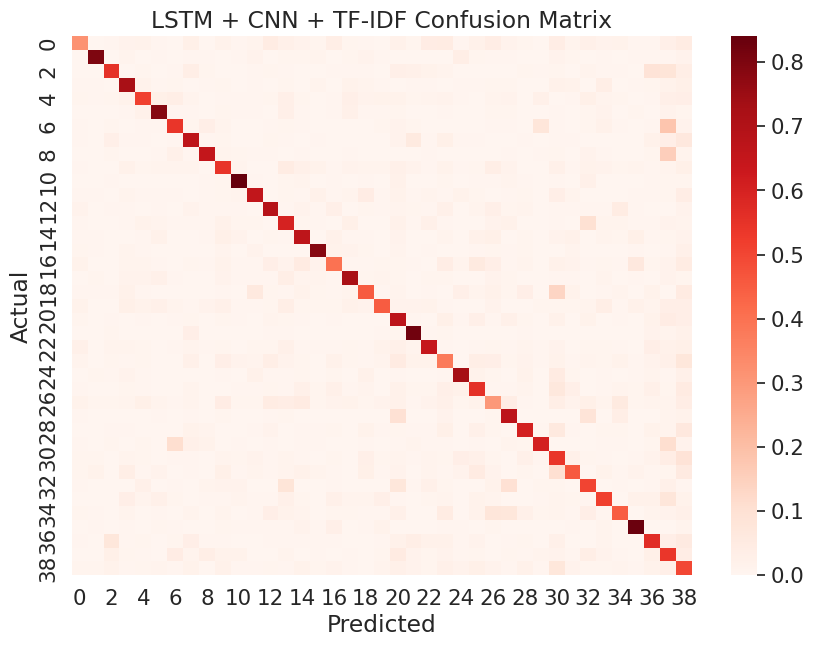

In [34]:
output_metrics(y_test_classes, y_pred_classes, normalize_cm=True, title_cm='LSTM + CNN + TF-IDF Confusion Matrix')
